# Debug: GD Overtraining + SGD with Weight Variance Analysis

In [1]:
import os
import sys
import torch
import numpy as np
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.utils import MNIST
from src.model import FlexibleMLP

In [2]:
# Настройки
SEED = 228
LR = 0.01
BATCH_SIZE = 64
GD_EPOCHS = 1000000
SGD_EPOCHS = 10
SAMPLE_SIZE = 1000

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

Device: cpu


In [3]:
# Загрузка данных
train_dataset, test_dataset, train_loader, test_loader = MNIST(
    batch_size=BATCH_SIZE, sample_size=SAMPLE_SIZE
)

# Создаем полный батч для GD
all_images = []
all_labels = []
for images, labels in train_loader:
    all_images.append(images)
    all_labels.append(labels)
full_batch_images = torch.cat(all_images, dim=0).to(DEVICE)
full_batch_labels = torch.cat(all_labels, dim=0).to(DEVICE)

# Создание модели
model = FlexibleMLP(
    hidden_dim=8,
    num_hidden_layers=1,
    input_downsample=6
).to(DEVICE)

criterion = nn.CrossEntropyLoss()

print(f"Параметров в модели: {sum(p.numel() for p in model.parameters())}")
print(f"Полный батч: {full_batch_images.shape[0]} образцов")

Параметров в модели: 386
Полный батч: 960 образцов


In [4]:
def vectorize_model(model):
    params = []
    for p in model.parameters():
        params.append(p.data.view(-1))
    return torch.cat(params).cpu().numpy()

def check_param_changes(params_before, params_after):
    diff = np.abs(params_after - params_before)
    return {
        'max_change': diff.max(),
        'mean_change': diff.mean(),
        'changed': (diff > 1e-8).any()
    }

In [5]:
# Этап 1: GD переобучение (1000 эпох)
model.train()
optimizer_gd = torch.optim.SGD(model.parameters(), lr=LR)

print("🚀 Этап 1: GD переобучение...")

for epoch in tqdm(range(GD_EPOCHS), desc="GD Overtraining"):
    optimizer_gd.zero_grad()
    outputs = model(full_batch_images)
    loss = criterion(outputs, full_batch_labels)
    loss.backward()
    optimizer_gd.step()
    
    if (epoch + 1) % 50000 == 0:
        print(f"GD Эпоха {epoch+1}: loss = {loss.item():.4f}")

print(f"✅ GD завершен. Финальный loss: {loss.item():.4f}")

🚀 Этап 1: GD переобучение...


GD Overtraining:   0%|          | 0/1000000 [00:00<?, ?it/s]

GD Overtraining:   5%|▌         | 50768/1000000 [00:14<04:08, 3825.34it/s]

GD Эпоха 50000: loss = 0.4792


GD Overtraining:  10%|█         | 100478/1000000 [00:27<03:57, 3789.15it/s]

GD Эпоха 100000: loss = 0.4105


GD Overtraining:  15%|█▌        | 150645/1000000 [00:40<03:46, 3744.33it/s]

GD Эпоха 150000: loss = 0.3781


GD Overtraining:  20%|██        | 200682/1000000 [00:53<03:29, 3818.22it/s]

GD Эпоха 200000: loss = 0.3557


GD Overtraining:  25%|██▌       | 250424/1000000 [01:07<03:24, 3659.06it/s]

GD Эпоха 250000: loss = 0.3352


GD Overtraining:  30%|███       | 300430/1000000 [01:21<03:05, 3774.89it/s]

GD Эпоха 300000: loss = 0.3155


GD Overtraining:  35%|███▌      | 350670/1000000 [01:34<02:52, 3764.41it/s]

GD Эпоха 350000: loss = 0.2987


GD Overtraining:  40%|████      | 400718/1000000 [01:48<02:37, 3802.00it/s]

GD Эпоха 400000: loss = 0.2845


GD Overtraining:  45%|████▌     | 450645/1000000 [02:02<02:24, 3813.24it/s]

GD Эпоха 450000: loss = 0.2719


GD Overtraining:  50%|█████     | 500547/1000000 [02:16<02:16, 3652.51it/s]

GD Эпоха 500000: loss = 0.2604


GD Overtraining:  55%|█████▌    | 550607/1000000 [02:30<01:57, 3811.24it/s]

GD Эпоха 550000: loss = 0.2497


GD Overtraining:  60%|██████    | 600548/1000000 [02:43<01:48, 3666.18it/s]

GD Эпоха 600000: loss = 0.2400


GD Overtraining:  65%|██████▌   | 650463/1000000 [02:56<01:34, 3687.62it/s]

GD Эпоха 650000: loss = 0.2315


GD Overtraining:  70%|███████   | 700406/1000000 [03:10<01:18, 3821.64it/s]

GD Эпоха 700000: loss = 0.2240


GD Overtraining:  75%|███████▌  | 750306/1000000 [03:23<01:10, 3544.58it/s]

GD Эпоха 750000: loss = 0.2171


GD Overtraining:  80%|████████  | 800396/1000000 [03:37<00:59, 3339.81it/s]

GD Эпоха 800000: loss = 0.2106


GD Overtraining:  85%|████████▌ | 850719/1000000 [03:51<00:38, 3828.45it/s]

GD Эпоха 850000: loss = 0.2047


GD Overtraining:  90%|█████████ | 900546/1000000 [04:04<00:25, 3847.13it/s]

GD Эпоха 900000: loss = 0.1992


GD Overtraining:  95%|█████████▌| 950781/1000000 [04:17<00:12, 3868.29it/s]

GD Эпоха 950000: loss = 0.1942


GD Overtraining: 100%|██████████| 1000000/1000000 [04:30<00:00, 3691.48it/s]

GD Эпоха 1000000: loss = 0.1895
✅ GD завершен. Финальный loss: 0.1895


In [6]:
# Этап 2: SGD с отслеживанием истории весов
model.train()
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=LR)
param_history = []
losses = []

# Сохраняем начальное состояние (после GD)
initial_params = vectorize_model(model)
param_history.append(initial_params.copy())

print("\n🚀 Этап 2: SGD с отслеживанием истории...")

for epoch in tqdm(range(SGD_EPOCHS), desc="SGD Training"):
    epoch_losses = []
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer_sgd.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
        
        # Сохраняем параметры после каждого батча
        param_history.append(vectorize_model(model))
        epoch_losses.append(loss.item())
    
    losses.extend(epoch_losses)
    print(f"Эпоха {epoch+1}: средний loss = {np.mean(epoch_losses):.4f}")

print(f"\nСохранено {len(param_history)} состояний параметров")

# Проверка изменений
final_params = param_history[-1]
changes = check_param_changes(initial_params, final_params)
print(f"\n📊 Изменения параметров после SGD:")
print(f"Максимальное: {changes['max_change']:.6f}")
print(f"Среднее: {changes['mean_change']:.6f}")
print(f"Изменились: {'✅ ДА' if changes['changed'] else '❌ НЕТ'}")


🚀 Этап 2: SGD с отслеживанием истории...


SGD Training:  40%|████      | 4/10 [00:00<00:00, 34.70it/s]

Эпоха 1: средний loss = 0.2367
Эпоха 2: средний loss = 0.2326
Эпоха 3: средний loss = 0.2330
Эпоха 4: средний loss = 0.2188
Эпоха 5: средний loss = 0.2372
Эпоха 6: средний loss = 0.2349
Эпоха 7: средний loss = 0.2362
Эпоха 8: средний loss = 0.2354


SGD Training: 100%|██████████| 10/10 [00:00<00:00, 40.88it/s]

Эпоха 9: средний loss = 0.2346
Эпоха 10: средний loss = 0.2390

Сохранено 151 состояний параметров

📊 Изменения параметров после SGD:
Максимальное: 0.012728
Среднее: 0.001536
Изменились: ✅ ДА


In [7]:
# Вычисляем дисперсию каждого веса вдоль траектории
param_history = np.array(param_history)
n_params = param_history.shape[1]

# Дисперсия каждого параметра по времени
param_variances = np.var(param_history, axis=0)

print(f"Всего параметров: {n_params}")
print(f"Дисперсии от {param_variances.min():.8f} до {param_variances.max():.8f}")
print(f"Средняя дисперсия: {param_variances.mean():.8f}")
print(f"Параметров с дисперсией < 1e-12: {(param_variances < 1e-12).sum()}")

Всего параметров: 386
Дисперсии от 0.00000000 до 0.00001352
Средняя дисперсия: 0.00000073
Параметров с дисперсией < 1e-12: 1


In [8]:
np.min((param_history.T - param_history.mean(axis=1))**2)

np.float32(1.3319351e-08)

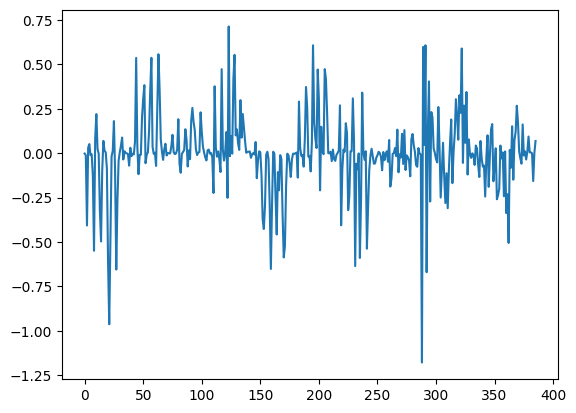

In [9]:
plt.plot(np.sum(param_history - param_history[0], axis = 0))

In [10]:
np.argwhere(param_variances < 10**(-8) * param_variances.mean())

array([], shape=(0, 1), dtype=int64)

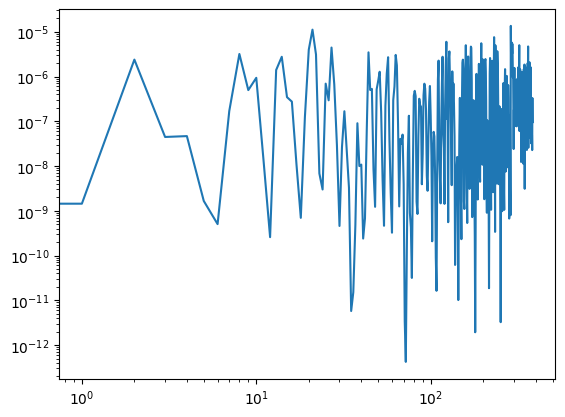

In [11]:
plt.loglog(param_variances)

In [69]:
params = []
for name, p in model.named_parameters():
    print( name, p.data.view(-1).shape)

model.0.weight torch.Size([288])
model.0.bias torch.Size([8])
model.2.weight torch.Size([80])
model.2.bias torch.Size([10])


In [77]:
import pickle
# Пути к данным
exp_dir = '../scripts/data/checkpoints/exp20'
learning_rates = [0.001, 0.01, 0.1, 0.5]

# Загружаем параметры для всех lr
all_params = {}
for lr in learning_rates:
    params_path = os.path.join(exp_dir, f'params_lr{lr}.pkl')
    print(f'Загружаем {params_path}...')
    
    if os.path.exists(params_path):
        with open(params_path, 'rb') as f:
            params = pickle.load(f)
        all_params[lr] = params
        print(f'  ✅ lr={lr}: {params.shape} (итераций × параметров)')
    else:
        print(f'  ❌ Файл не найден: {params_path}')

print(f'\nЗагружено {len(all_params)} наборов параметров')

# Определяем размеры для слайсов
if all_params:
    total_params = list(all_params.values())[0].shape[1]
    print(f'Общее количество параметров: {total_params}')

Загружаем ../scripts/data/checkpoints/exp20/params_lr0.001.pkl...
  ✅ lr=0.001: (1020, 386) (итераций × параметров)
Загружаем ../scripts/data/checkpoints/exp20/params_lr0.01.pkl...
  ✅ lr=0.01: (1020, 386) (итераций × параметров)
Загружаем ../scripts/data/checkpoints/exp20/params_lr0.1.pkl...
  ✅ lr=0.1: (1020, 386) (итераций × параметров)
Загружаем ../scripts/data/checkpoints/exp20/params_lr0.5.pkl...
  ✅ lr=0.5: (1020, 386) (итераций × параметров)

Загружено 4 наборов параметров
Общее количество параметров: 386


In [80]:
p = all_params[0.01]
p.shape

(1020, 386)

In [ ]:
d

np.float32(0.0)

In [91]:
p[5][175]

np.float32(0.11718037)

In [88]:
std_p = p.std(axis=0)

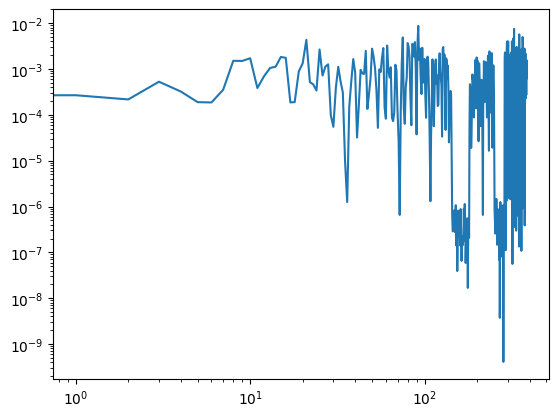

In [89]:
plt.loglog(std_p)